In [1]:
import os
import numpy as np
import tarfile
from six.moves import urllib
import pandas as pd
import matplotlib.pyplot as plt
plt.ion()
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import Imputer
from sklearn.preprocessing import LabelBinarizer, Normalizer
#import plotly.plotly as ply

In [2]:
# get the housing data
DOWNLOAD_ROOT =  'https://raw.githubusercontent.com/ageron/handson-ml/master/'
HOUSING_PATH = 'datasets/housing'
HOUSING_FILE = 'housing.tgz'
HOUSING_URL = DOWNLOAD_ROOT + HOUSING_PATH + '/' + HOUSING_FILE

# make the directory if needed
if not(os.path.isdir(HOUSING_PATH)):
    os.makedirs(HOUSING_PATH)
# get the file
tgz_path = os.path.join(HOUSING_PATH,HOUSING_FILE)
try:
    print('Downloading from: '+HOUSING_URL + " to "+tgz_path)
    urllib.request.urlretrieve(HOUSING_URL,tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=HOUSING_PATH)
    housing_tgz.close()
except Exception as e:
    raise e

In [3]:
# verify the file was downloaded & extracted
os.listdir(HOUSING_PATH)

['housing.csv', 'housing.tgz']

In [4]:
# get the data into a pandas dataframe
housing_data = pd.read_csv(os.path.join(HOUSING_PATH,'housing.csv'))
# explore a little
print(housing_data.columns)
print(housing_data.head())
print(housing_data.describe())

Index(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income',
       'median_house_value', 'ocean_proximity'],
      dtype='object')
   longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
0    -122.23     37.88                41.0        880.0           129.0   
1    -122.22     37.86                21.0       7099.0          1106.0   
2    -122.24     37.85                52.0       1467.0           190.0   
3    -122.25     37.85                52.0       1274.0           235.0   
4    -122.25     37.85                52.0       1627.0           280.0   

   population  households  median_income  median_house_value ocean_proximity  
0       322.0       126.0         8.3252            452600.0        NEAR BAY  
1      2401.0      1138.0         8.3014            358500.0        NEAR BAY  
2       496.0       177.0         7.2574            352100.0        NEAR BAY  
3       558.0       219

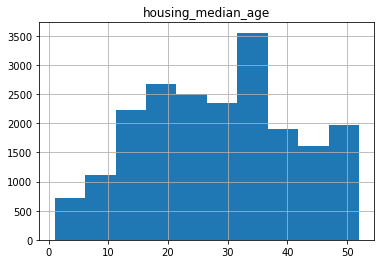

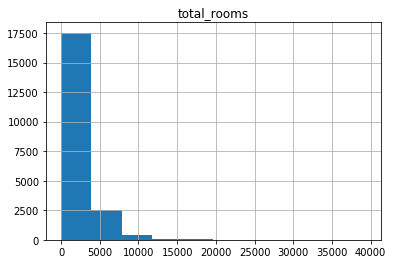

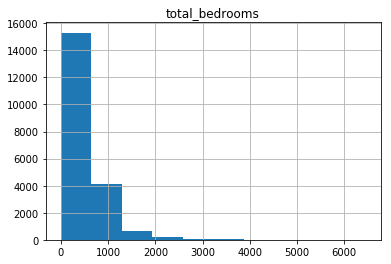

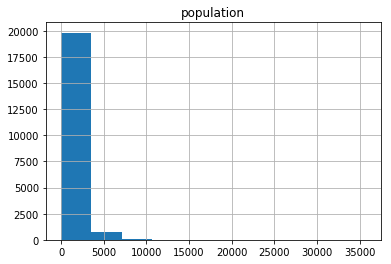

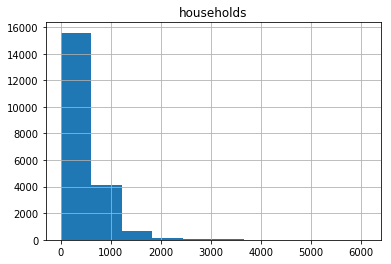

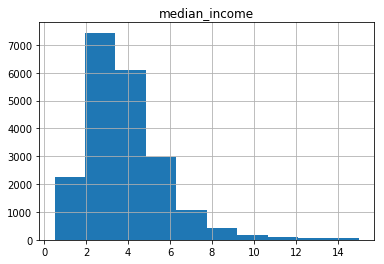

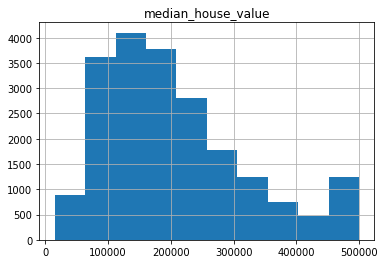

In [5]:
# look at some histograms
histme = ['housing_median_age', 'total_rooms','total_bedrooms', 'population', 'households', 'median_income','median_house_value']
for col in histme:
    plt.figure()
    thisax = plt.gca()
    housing_data[col].hist(ax = thisax)
    plt.title(col)

There is a clear problem with *total_rooms* and *total_bedrooms*, which should probably not be in the hundreds. Also, there appears to be some arbitrary cutoff of 500,000 for *median_house_value*.

In [6]:
# see the distribution of ocean proximity labels
housing_data.ocean_proximity.value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

In [ ]:
# create an income categorical value - 5 groups
housing_data['median_income_category'] = np.ceil(housing_data.median_income/1.5)
housing_data.median_income_category.where(housing_data.median_income_category<5,5,inplace=True)
housing_data.median_income_category = pd.Categorical(housing_data.median_income_category)
housing_data.median_income_category.value_counts()

In [ ]:
# partition into training & testing sets
# first create a function to do it:
def StratPartition(training_perc,split_seed,data,categories):
    sss = StratifiedShuffleSplit(n_splits=1, random_state = split_seed, train_size = training_perc)
    # actually partition
    for trn,tst in sss.split(data,categories):
        trnset = data.loc[trn]
        tstset = data.loc[tst]    
    return trnset,tstset

# now create a set of training & testing data
split_seed = 19062018
training_perc = 0.8
housing_trn,housing_tst = StratPartition(training_perc,split_seed,housing_data,housing_data.median_income_category)

In [ ]:
# verify splits are stratified
print('All Data:')
print(housing_data.median_income_category.value_counts()/housing_data.median_income_category.count())
print('Training Set:')
print(housing_trn.median_income_category.value_counts()/housing_trn.median_income_category.count())
print('Testing Set:')
print(housing_tst.median_income_category.value_counts()/housing_tst.median_income_category.count())

In [ ]:
# check Lat & Lon to see if it looks like California
housing_trn.plot(kind='scatter',x='longitude',y='latitude',alpha=0.4,
                 s=housing_trn.population/100,c=housing_trn.median_house_value,
                 cmap=plt.get_cmap('jet'),colorbar=True,label='Population',figsize=[10,7])

In [ ]:
# get the linear correlations to the median house value
housing_trn.corr().median_house_value.sort_values(ascending=False)

In [ ]:
# let's see the scatter plot matrix from some of these vars
seld = ['median_house_value','median_income','total_rooms','housing_median_age','latitude']
pd.plotting.scatter_matrix(housing_trn[seld],figsize=[10,10])

Should probably do the following:
- remove observartions for number of rooms too big
- possibly remove observations related to strange horizontal lines in *median_house_value* at the strange horizontal lines in the plot vs. *median_income*

# Exploratory work is done, so create final data for ML Modeling

In [ ]:
# do a bit of feature engineering
housing_data['rooms_per_house'] = housing_data.total_rooms/housing_data.households
housing_data['bedrooms_per_house'] = housing_data.total_bedrooms/housing_data.households
housing_data['population_per_house'] = housing_data.population/housing_data.households

In [ ]:
# recheck correlations
print(housing_data.corr().median_house_value.sort_values(ascending=False))

In [ ]:
# recreate a set of training & testing data
housing_trn,housing_tst = StratPartition(training_perc,split_seed,housing_data,housing_data.median_income_category)
# separate the labels
housing_trn_y = housing_trn.median_house_value
housing_trn_X = housing_trn.drop('median_house_value',axis=1)
housing_tst_y = housing_tst.median_house_value
housing_tst_X = housing_tst.drop('median_house_value',axis=1)

In [ ]:
# separate out the ocean_proximity variable
ocean_trn = housing_trn_X.ocean_proximity
housing_trn_X.drop('ocean_proximity',inplace=True,axis=1)
ocean_tst = housing_tst_X.ocean_proximity
housing_tst_X.drop('ocean_proximity',inplace=True,axis=1)

In [ ]:
# make the ocean proximity variable categorical & OHE
enc = LabelBinarizer()
enc.fit(ocean_trn)
ocean_trn = enc.transform(ocean_trn)
ocean_tst = enc.transform(ocean_tst)
# create the column labels
ocean_cols = ['ocean_proximity_%d'%i for i in range(len(housing_data.ocean_proximity.value_counts()))]

In [ ]:
# let's get the stats to impute missing values - from the training set
imp = Imputer(strategy='median')
imp.fit(housing_trn_X)
# now impute the missing values for the training & test sets
trn = imp.transform(housing_trn_X)
tst = imp.transform(housing_tst_X)

In [ ]:
# normalize; based on training data of course
nrm = Normalizer()
trn = nrm.fit_transform(trn)
tst = nrm.transform(tst)
# show the data has been normalized
print(np.min(trn,axis=0))
print(np.max(trn,axis=0))

In [ ]:
# now put the data back together into a dataframe
keptcols = housing_trn_X.columns.tolist()
keptcols.extend(ocean_cols)
housing_trn_X = pd.DataFrame(np.c_[trn,ocean_trn],columns = keptcols)
housing_tst_X = pd.DataFrame(np.c_[tst,ocean_tst],columns=keptcols)
# talk a little
print(housing_trn_X.describe())